# OpenHAP Measurement Normalization Framework

![title](../../images/measurementNormalization.png)

## Import required libraries

In [1]:
import os
import csv
import time
import glob
import datetime
import pandas as pd
import paho.mqtt.client as mqtt
from matplotlib import pyplot as plt
from IPython import display

## Setup defaults

### Setup broker specifics

In [2]:
broker_address = "127.0.0.1"

In [3]:
broker_qos, command_qos, measurement_qos = 2,2,2

In [4]:
system_mid, command_mid, measurement_mid = 0,0,0

In [5]:
openhap_clients_in_test = 20

In [6]:
connected_units = 0

Change the command interval variable below in proportion to the number of devices in the test to avoid data congestion

In [7]:
command_interval = 8

### Setup dataframe and file specifics

In [8]:
command_sent_time_txt = "Command sent time(UTC)"
measurement_received_time_txt = "Measurement received time (UTC)"
device_field_txt = "Device"
device_time_field_txt = "Device time (UTC)"
measurement_field_txt = "Particulate measurement"
connected_openhap_units_field_txt = "Connected OpenHAP units"

In [9]:
csv_fieldnames = [command_sent_time_txt, measurement_received_time_txt, device_field_txt, 
                  device_time_field_txt, measurement_field_txt, connected_openhap_units_field_txt]

In [10]:
measurement_file = "chamberTest.csv"

## Setup dataframes and the live plotting function

In [11]:
measurement_df = pd.DataFrame(columns=csv_fieldnames)

In [12]:
%matplotlib inline

def live_plot():
    measurement_df_copy = measurement_df.copy()
    measurement_df_copy.set_index(command_sent_time_txt, inplace=True)
    measurement_df_copy.groupby(device_field_txt)[measurement_field_txt].plot(legend=True, 
                                                                              figsize=(20,10), 
                                                                              grid=True)
    display.clear_output(wait=True)
    plt.show();

## Setup event callbacks

In [13]:
def on_connect(client, userdata, flags, rc):
    global system_mid, command_mid, measurement_mid
    if rc == 0:
        print("Connected OK")
        system_mid = client.subscribe("$SYS/broker/clients/#", broker_qos)[-1]
        command_mid = client.subscribe("command", command_qos)[-1]
        measurement_mid = client.subscribe("measurement/#", measurement_qos)[-1]

In [14]:
def on_subscribe(client, userdata, mid, granted_qos): 
    if mid == measurement_mid:
        print("measurement topics successfully subscribed")
    elif mid == command_mid:
        print("Command topic successfully subscribed")
    elif mid == system_mid:
        print("System topic successfully subscribed")
    else:
        print("Other topic subscription acknowledgement received")

In [15]:
def on_message(client, userdata, message):
    global connected_units, measurement_df
    if message.topic == "command":
        print("Measurement command sent!")
    if "measurement" in message.topic:
            measurement_received_time = int(time.time())
            mqtt_topic_levels = message.topic.split('/')
            if len(mqtt_topic_levels) != 2:
                print("Improperly formatted measurement topic received")
            else:
                payload = str(message.payload, 'utf-8').split(',')
                
                device = mqtt_topic_levels[1]
                
                command_sent_time = int(payload[0])
                measurement = float(payload[1])
                device_time = int(payload[2])
                
                #Not ideal to expand a dataframe...but it will do
                temp = pd.DataFrame([[command_sent_time,
                                      measurement_received_time,
                                      device,
                                      device_time,
                                      measurement,
                                      connected_units]], columns = csv_fieldnames)
                
                temp[command_sent_time_txt] = pd.to_datetime(temp[command_sent_time_txt], unit='s')
                temp[measurement_received_time_txt] = pd.to_datetime(temp[measurement_received_time_txt], unit='s')
                temp[device_time_field_txt] = pd.to_datetime(temp[device_time_field_txt], unit='s')
                temp[measurement_field_txt]= temp[measurement_field_txt].astype(float)
                
                measurement_df = pd.concat([measurement_df, temp])
    if "connected" in message.topic:
        connected_units = int(str(message.payload, 'utf-8'))
        print(f"{connected_units} MQTT clients connected to broker, including measurement controller")

## Test code

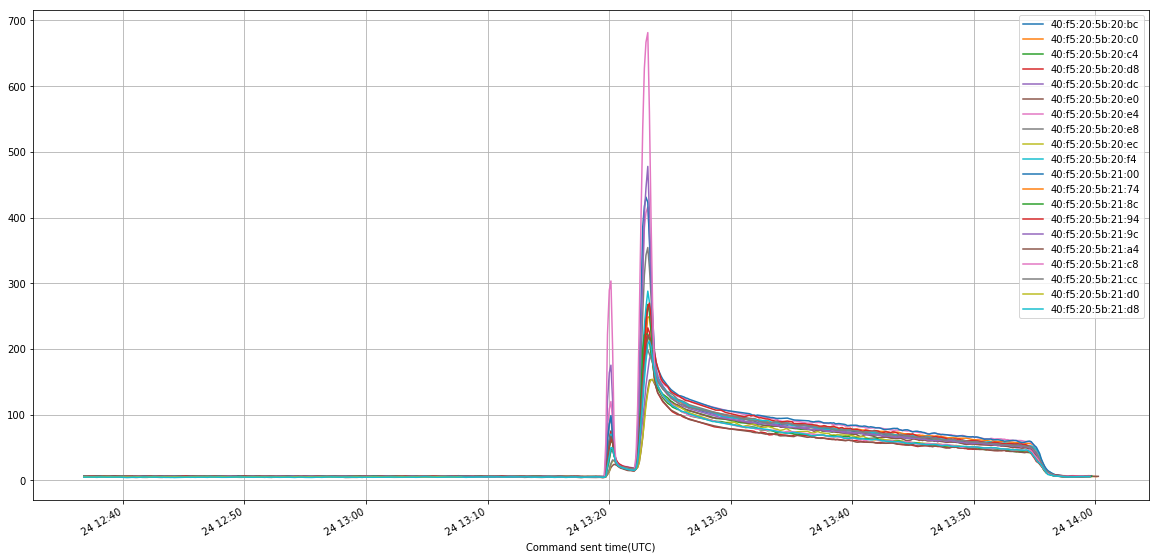

Measurement command sent!
Event loop thread stopped and CSV written


In [16]:
file_present = glob.glob(measurement_file)

if file_present:
    os.remove(measurement_file)

controller = mqtt.Client("controller",clean_session=True)

controller.max_inflight_messages_set(30)

controller.on_connect = on_connect
controller.on_subscribe = on_subscribe
controller.on_message = on_message

controller.connect(broker_address)
last_publish_time = time.time()
while True:
    try:
        controller.loop(timeout=0.5, max_packets = openhap_clients_in_test)
        time_now = time.time()
        if (time_now - last_publish_time) > command_interval:
            live_plot()
            controller.publish("command", int(time_now))
            last_publish_time = time_now
    except KeyboardInterrupt:
        controller.disconnect()
        measurement_df.to_csv(measurement_file, encoding = "utf-8", index = False)
        measurement_df = pd.DataFrame(columns=measurement_df.columns)
        print("CSV written")
        break